In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string

from wordcloud import WordCloud
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
import pickle

import warnings
warnings.filterwarnings('ignore')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/email-spam-detection-dataset-classification/spam.csv
/kaggle/input/spam-email-dataset/emails.csv
/kaggle/input/email-spam-classification/email_spam.csv
/kaggle/input/email-spam-classification-dataset-csv/emails.csv


**DATA COLLECTION**

In [3]:
# Load the dataset as a Pandas DataFrame
df = pd.read_csv("/kaggle/input/email-spam-detection-dataset-classification/spam.csv",encoding="latin-1")

# Check the first few rows of the dataset
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df=pd.DataFrame(df)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [6]:
df.shape

(5572, 5)

In [7]:
df.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [8]:
df['text'] = df['v2'].astype('str') + ',' + df['Unnamed: 2'].astype('str') + ',' + df['Unnamed: 3'].astype('str') + ',' + df['Unnamed: 4'].astype('str')

In [9]:
df['text']

0       Go until jurong point, crazy.. Available only ...
1               Ok lar... Joking wif u oni...,nan,nan,nan
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568    Will Ì_ b going to esplanade fr home?,nan,nan,nan
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571               Rofl. Its true to its name,nan,nan,nan
Name: text, Length: 5572, dtype: object

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
 5   text        5572 non-null   object
dtypes: object(6)
memory usage: 261.3+ KB


In [11]:
df['v1'] = df.rename(columns={"v1": "email"}, inplace=True)
df.head()

,email,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4,text,v1
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN,"Go until jurong point, crazy.. Available only ...",None
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN,"Ok lar... Joking wif u oni...,nan,nan,nan",None
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN,Free entry in 2 a wkly comp to win FA Cup fina...,None
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN,U dun say so early hor... U c already then say...,None
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN,"Nah I don't think he goes to usf, he lives aro...",None


In [12]:
df.drop(columns = ['Unnamed: 2',	'Unnamed: 3',	'Unnamed: 4','v1','v2'],inplace = True)

In [13]:
df.head()

,email,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,"Ok lar... Joking wif u oni...,nan,nan,nan"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [14]:
df.drop_duplicates(inplace=True)

In [15]:
df.shape

(5169, 2)

**EXPLORATORY DATA ANALYSIS**

In [16]:
df['email'].value_counts()/len(df)*100

email
ham     87.366996
spam    12.633004
Name: count, dtype: float64

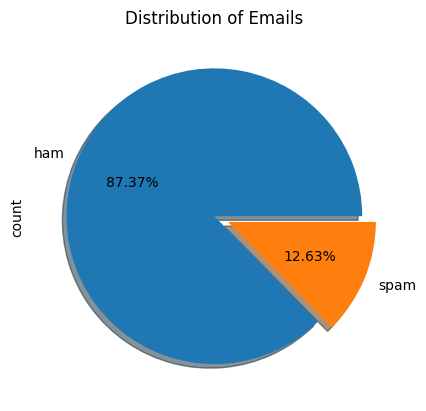

In [17]:
df['email'].value_counts().plot(kind='pie', autopct='%.2f%%', shadow=True, explode=[0,0.1])
plt.title("Distribution of Emails")
plt.show()

In [115]:
# Count number of characters
df['num_characters'] = df['text'].apply(len)

In [116]:
# Count number of words
df['num_words'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))

In [117]:
# Count number of sentences
df['num_sentences'] = df['text'].apply(lambda x: len(nltk.sent_tokenize(x)))

In [118]:
df.head()

,email,text,num_characters,num_words,num_sentences
0,ham,"Go until jurong point, crazy.. Available only ...",123,29,2
1,ham,"Ok lar... Joking wif u oni...,nan,nan,nan",41,14,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,167,43,2
3,ham,U dun say so early hor... U c already then say...,61,19,1
4,ham,"Nah I don't think he goes to usf, he lives aro...",73,21,1


In [119]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
num_characters,5169.0,91.494099,58.430193,14.0,48.0,73.0,131.0,922.0
num_words,5169.0,24.183788,13.272240,7.0,15.0,21.0,32.0,225.0
num_sentences,5169.0,1.981621,1.450636,1.0,1.0,2.0,2.0,38.0


In [120]:
# ham text
df[df['email']=='ham'][['num_characters','num_words','num_sentences']].describe().T

,count,mean,std,min,25%,50%,75%,max
num_characters,4516.0,83.013950,56.650568,14.0,46.0,65.0,104.0,922.0
num_words,4516.0,22.844996,13.439496,7.0,14.0,19.0,28.0,225.0
num_sentences,4516.0,1.836581,1.385209,1.0,1.0,1.0,2.0,38.0


In [121]:
 #ham text
df[df['email']=='spam'][['num_characters','num_words','num_sentences']].describe().T

,count,mean,std,min,25%,50%,75%,max
num_characters,653.0,150.140888,29.911860,25.0,144.0,161.0,169.0,236.0
num_words,653.0,33.442573,6.871196,8.0,31.0,35.0,38.0,50.0
num_sentences,653.0,2.984686,1.496339,1.0,2.0,3.0,4.0,9.0


In [122]:
import seaborn as sns


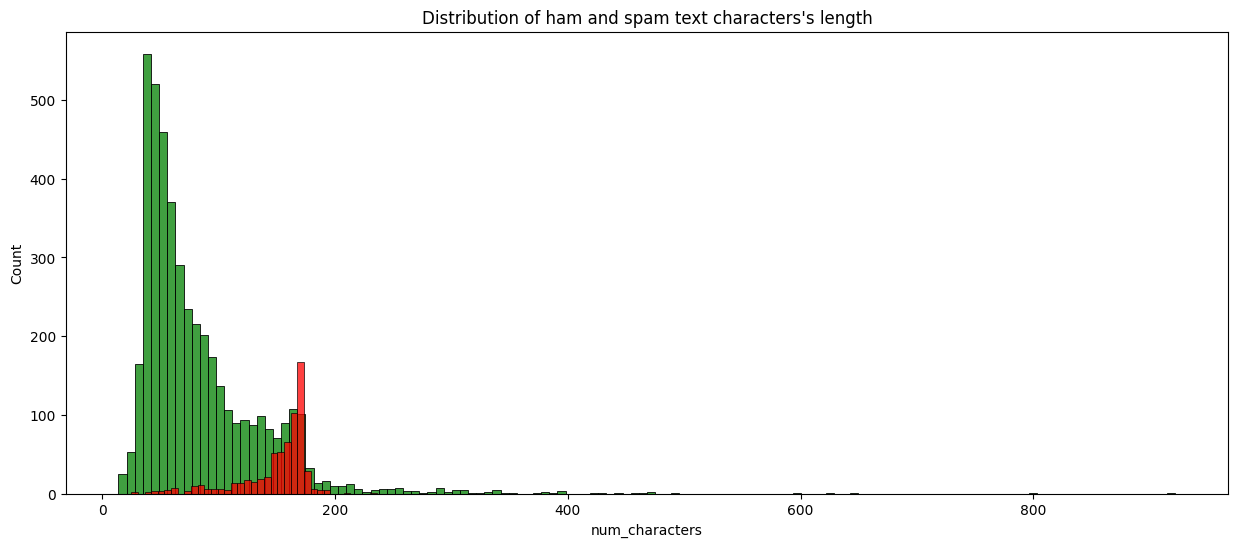

In [123]:
# Histogram for 'ham' and 'spam' text
plt.figure(figsize=(15,6))
sns.histplot(df[df['email']=='ham']['num_characters'], color = 'green')
sns.histplot(df[df['email']=='spam']['num_characters'], color='red')
plt.title("Distribution of ham and spam text characters's length")
plt.show()

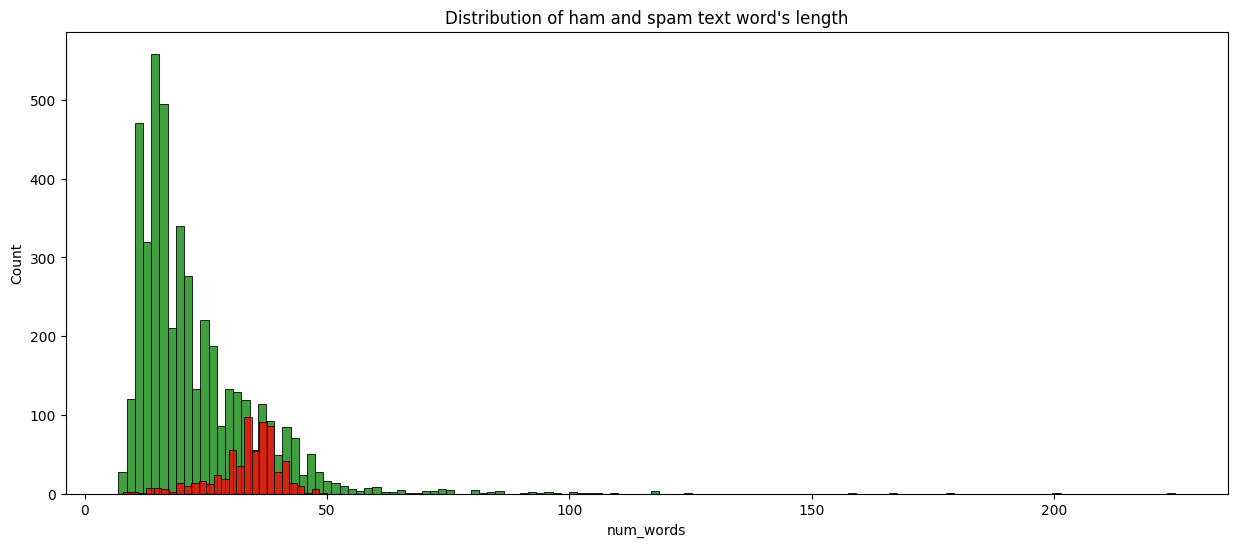

In [124]:
# Histogram for 'ham' and 'spam' text
plt.figure(figsize=(15,6))
sns.histplot(df[df['email']=='ham']['num_words'],color = 'green')
sns.histplot(df[df['email']=='spam']['num_words'], color='red')
plt.title("Distribution of ham and spam text word's length")
plt.show()

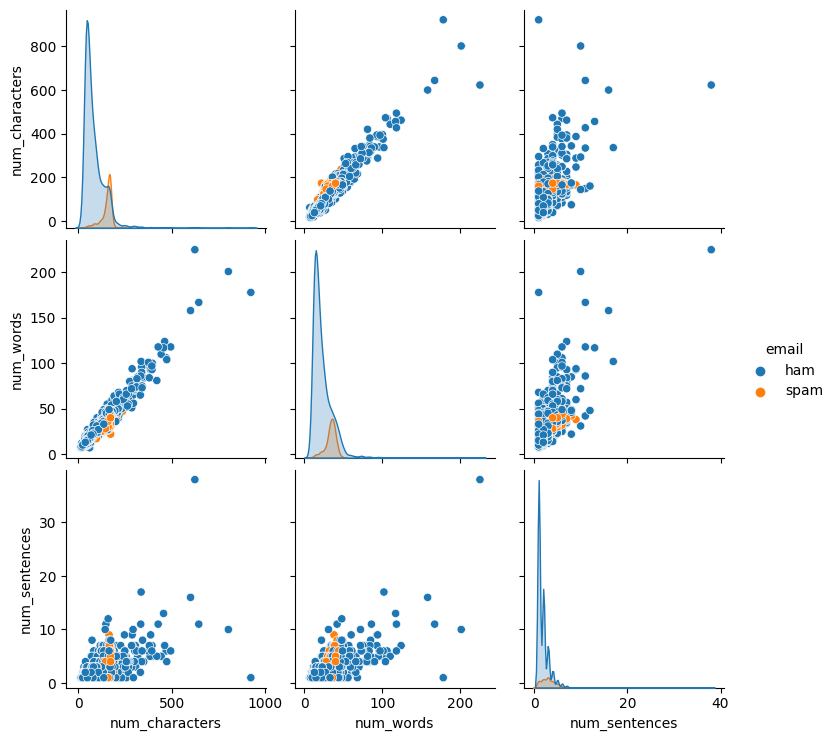

In [125]:
sns.pairplot(df, hue='email')
plt.show()

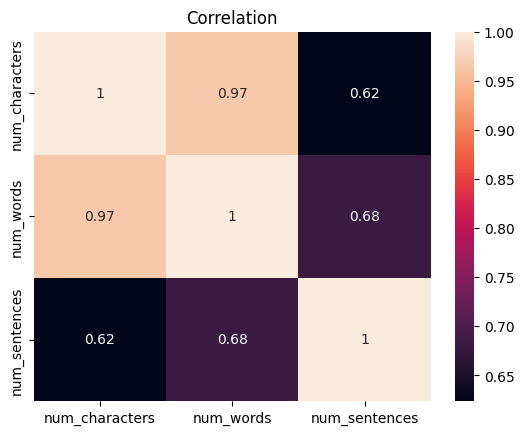

In [126]:
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True)
plt.title("Correlation")
plt.show();

In [127]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [128]:
x = df.drop(columns=['text'],axis=1)
y = df['email']

In [132]:
# Function for text preprocessing
def transform_text(text):
    text = text.lower()   # Lower-case
    text = nltk.word_tokenize(text)   # Tokenize the text on  word level

    y = []
    for i in text:
        if i.isalnum():    # Check whether the text is either alpha or numeric
            y.append(i)    # If yes, append otherwise, remove special characters

    text = y[:]
    y.clear()

    for j in text:    # Removing stopwords
        if j not in stopwords.words('english') and j not in string.punctuation:
            y.append(j)

    text = y[:]
    y.clear()

    for k in  text:
        y.append(ps.stem(k))    # Convert the word to root form

    return " ".join(y)

In [133]:
df.head()

,email,text,num_characters,num_words,num_sentences
0,ham,"Go until jurong point, crazy.. Available only ...",123,29,2
1,ham,"Ok lar... Joking wif u oni...,nan,nan,nan",41,14,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,167,43,2
3,ham,U dun say so early hor... U c already then say...,61,19,1
4,ham,"Nah I don't think he goes to usf, he lives aro...",73,21,1


**VECTORIZATION**

In [30]:
# Encode target feature
df['email'] = df['email'].map({'ham': 0, 'spam':1})
df['email'].head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: email, dtype: float64

In [31]:
y = df['email'].values
y

array([nan, nan, nan, ..., nan, nan, nan])